<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# LightGBM: A Highly Efficient Gradient Boosting Decision Tree
This notebook gives an example of how to train a LightGBM model to generate point forecasts of product sales in retail. We will train a LightGBM based model on the OrangeJuice dataset.

[LightGBM](https://github.com/Microsoft/LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is an ensemble technique in which models are added to the ensemble sequentially and at each iteration a new model is trained with respect to the error of the whole ensemble learned so far. More detailed information about gradient boosting can be found in this [tutorial paper](https://www.frontiersin.org/articles/10.3389/fnbot.2013.00021/full). Using this technique, LightGBM achieves great accuracy in many applications. Apart from this, it is designed to be distributed and efficient with the following advantages:
* Fast training speed and high efficiency.
* Low memory usage.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

Due to these advantages, LightGBM has been widely-used in a lot of [winning solutions](https://github.com/microsoft/LightGBM/blob/master/examples/README.md#machine-learning-challenge-winning-solutions) of machine learning competitions.

## Global Settings and Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import math
import random
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb

import warnings

warnings.filterwarnings("ignore")

from forecasting_lib.evaluation.evaluation_utils import MAPE
import forecasting_lib.dataset.retail.benchmark_settings as bs

print("System version: {}".format(sys.version))
print("LightGBM version: {}".format(lgb.__version__))

System version: 3.6.10 |Anaconda, Inc.| (default, Jan  7 2020, 21:14:29) 
[GCC 7.3.0]
LightGBM version: 2.3.1


## Parameter Setting

In what follows, we define global settings related to the model and feature selection. LightGBM supports both classification model and regression model. In our case, we set the objective function to `mape` which stands for mean absolute percentage error (MAPE) since we will build a regression model to predict product sales and evaluate the accuracy of the model using MAPE.

Generally, we can adjust the number of leaves (`num_leaves`), the minimum number of data in each leaf (`min_data_in_leaf`), maximum number of boosting rounds (`num_rounds`), the learning rate of trees (`learning_rate`) and `early_stopping_rounds` (to avoid overfitting) in the model to get better performance. Note that `num_rounds` controls the maximum number of

Besides, we can also adjust some other listed parameters to optimize the results. [In this link](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst), a list of all the parameters is shown. Also, some advice on how to tune these parameters can be found [in this url](https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst).


In [3]:
# Data paths
DATA_DIR = "../../contrib/tsperf/OrangeJuice_Pt_3Weeks_Weekly/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameters of GBM model
params = {
    "objective": "mape",
    "num_leaves": 124,
    "min_data_in_leaf": 340,
    "learning_rate": 0.1,
    "feature_fraction": 0.65,
    "bagging_fraction": 0.87,
    "bagging_freq": 19,
    "num_rounds": 940,
    "early_stopping_rounds": 125,
    "num_threads": 16,
    "verbose_eval": 20,
    "seed": 1,
}

# Lags and categorical features
lags = np.arange(2, 20)
window_size = 40
used_columns = ["store", "brand", "week", "week_of_month", "month", "deal", "feat", "move", "price", "price_ratio"]
categ_fea = ["store", "brand", "deal"]

In [4]:
# Utility functions
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """
    from math import ceil

    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom / 7.0))
    return wom


def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product

    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df


def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + "_lag" + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea


def moving_averages(df, start_step, window_size=None):
    """Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
        start_step (Integer): Starting time step of rolling mean
        window_size (Integer): Windows size of rolling mean
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size is None:  # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + "_mean"
    return fea


def combine_features(df, lag_fea, lags, window_size, used_columns):
    """Combine different features for a certain store-brand.
    
    Args:
        df (Dataframe): Time series data of a certain store-brand
        lag_fea (List): A list of column names for creating lagged features
        lags (Numpy Array): Numpy array including all the lags
        window_size (Integer): Windows size of rolling mean
        used_columns (List): A list of names of columns used in model training (including target variable)
    
    Returns:
        fea_all (Dataframe): Dataframe including all features for the specific store-brand
    """
    lagged_fea = lagged_features(df[lag_fea], lags)
    moving_avg = moving_averages(df[lag_fea], 2, window_size)
    fea_all = pd.concat([df[used_columns], lagged_fea, moving_avg], axis=1)
    return fea_all


def make_predictions(df, model):
    """Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({"move": model.predict(df.drop("move", axis=1))})
    predictions["move"] = predictions["move"].apply(lambda x: round(x))
    return pd.concat([df[["brand", "store", "week"]].reset_index(drop=True), predictions], axis=1)


def evaluate(result):
    """Compute MAPE value of the forecast.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(result["move"], result["actual"]) * 100


def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store == store) & (results.brand == brand)]
    subset = subset[["week", "move", "actual"]].set_index("week")
    print("Sample MAPE is {}".format(evaluate(subset)))
    ax = subset.plot()
    ax.set_title("Forecast result of brand {} at store {}".format(brand, store))
    ax.set_ylabel("unit sales")
    ax.set_ylim(bottom=0)
    ax.legend(labels=["predicted", "actual"])

In [5]:
# Train and predict for all forecast rounds

r = 0
print("---- Round " + str(r + 1) + " ----")
# Load training data
train_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_round_" + str(r + 1) + ".csv"))
train_df["move"] = train_df["logmove"].apply(lambda x: round(math.exp(x)))
print(train_df.head(3))
print("")
train_df = train_df[["store", "brand", "week", "move"]]

# Create a dataframe to hold all necessary data
store_list = train_df["store"].unique()
brand_list = train_df["brand"].unique()
week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r] + 1)
d = {"store": store_list, "brand": brand_list, "week": week_list}
data_grid = df_from_cartesian_product(d)
data_filled = pd.merge(data_grid, train_df, how="left", on=["store", "brand", "week"])

# Get future price, deal, and advertisement info
aux_df = pd.read_csv(os.path.join(TRAIN_DIR, "aux_round_" + str(r + 1) + ".csv"))
data_filled = pd.merge(data_filled, aux_df, how="left", on=["store", "brand", "week"])

# Create relative price feature
price_cols = [
    "price1",
    "price2",
    "price3",
    "price4",
    "price5",
    "price6",
    "price7",
    "price8",
    "price9",
    "price10",
    "price11",
]
data_filled["price"] = data_filled.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
data_filled["avg_price"] = data_filled[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
data_filled["price_ratio"] = data_filled["price"] / data_filled["avg_price"]
data_filled.drop(price_cols, axis=1, inplace=True)

# Fill missing values
print("Number of missing rows is {}".format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
print("")
data_filled = data_filled.groupby(["store", "brand"]).apply(lambda x: x.fillna(method="ffill").fillna(method="bfill"))

# Create datetime features
data_filled["week_start"] = data_filled["week"].apply(
    lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x - 1) * 7)
)
data_filled["year"] = data_filled["week_start"].apply(lambda x: x.year)
data_filled["month"] = data_filled["week_start"].apply(lambda x: x.month)
data_filled["week_of_month"] = data_filled["week_start"].apply(lambda x: week_of_month(x))
data_filled["day"] = data_filled["week_start"].apply(lambda x: x.day)
data_filled.drop("week_start", axis=1, inplace=True)

# Create other features (lagged features, moving averages, etc.)
features = data_filled.groupby(["store", "brand"]).apply(
    lambda x: combine_features(x, ["move"], lags, window_size, used_columns)
)
train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
print("Maximum training week number is {}".format(max(train_fea["week"])))
print("")

# Drop rows with NaN values
train_fea.dropna(inplace=True)
print(train_fea.head(1))
print("")

print("Training and predicting models...")
# Create training set
dtrain = lgb.Dataset(train_fea.drop("move", axis=1, inplace=False), label=train_fea["move"])
if r % 3 == 0:
    # Train GBM model
    print("Training model...")
    bst = lgb.train(params, dtrain, valid_sets=[dtrain], categorical_feature=categ_fea, verbose_eval=False)

# Generate forecasts
test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
pred = make_predictions(test_fea, bst).sort_values(by=["store", "brand", "week"]).reset_index(drop=True)
# Additional columns required by the submission format
pred["round"] = r + 1
pred["weeks_ahead"] = pred["week"] - bs.TRAIN_END_WEEK_LIST[r]
print(pred)
print("")

# Evaluate prediction accuracy
test_df = pd.read_csv(os.path.join(TEST_DIR, "test_round_" + str(r + 1) + ".csv"))
test_df["actual"] = test_df["logmove"].apply(lambda x: round(math.exp(x)))
test_df.drop("logmove", axis=1, inplace=True)
combined = pd.merge(pred, test_df, on=["store", "brand", "week"], how="left")
metric_value = evaluate(combined)
print("")
print("MAPE of current round is {}".format(metric_value))
print("")

---- Round 1 ----
   store  brand  week   logmove  constant    price1    price2    price3  \
0      2      1    40  9.018695         1  0.060469  0.060497  0.042031   
1      2      1    46  8.723231         1  0.060469  0.060312  0.045156   
2      2      1    47  8.253228         1  0.060469  0.060312  0.045156   

     price4    price5    price6    price7    price8    price9   price10  \
0  0.029531  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844   
1  0.046719  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031   
2  0.046719  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656   

    price11  deal  feat     profit  move  
0  0.038984     1   0.0  37.992326  8256  
1  0.038984     0   0.0  30.126667  6144  
2  0.038984     0   0.0  30.000000  3840  

Number of missing rows is 6204

Maximum training week number is 135

    store  brand  week  week_of_month  month  deal  feat    move     price  \
19      2      1    59              4     10   1.0   0.0  83

Plot feature importances...


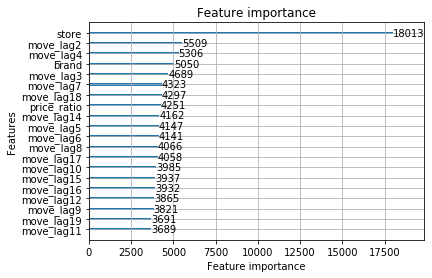

In [9]:
import matplotlib.pyplot as plt

print("Plot feature importances...")
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

Sample MAPE is 18.046667220744684
Sample MAPE is 27.135416666666668
Sample MAPE is 13.861083984375
Sample MAPE is 58.92036548094437
Sample MAPE is 50.310132575757585


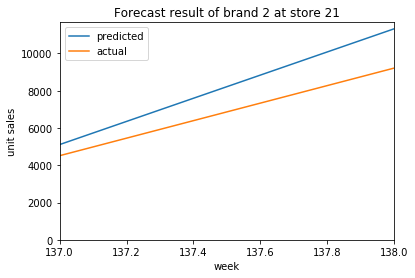

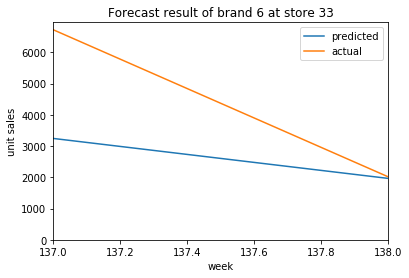

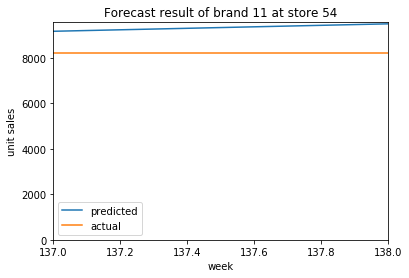

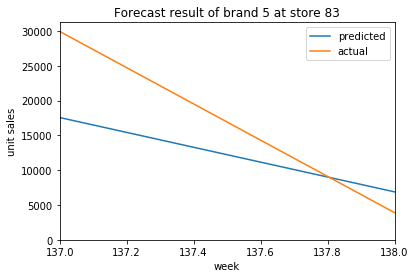

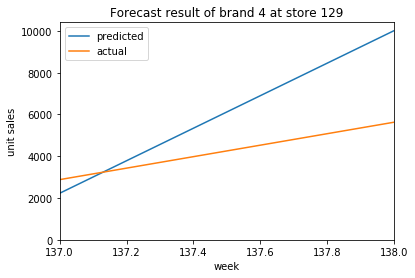

In [8]:
# Visualize forecast results
results = pd.concat([combined], axis=0)
random.seed(2)
for _ in range(5):
    store = random.choice(results["store"].unique())
    brand = random.choice(results["brand"].unique())
    plot_result(results, store, brand)

## Additional Reading

\[1\] Guolin Ke, Qi Meng, Thomas Finley, Taifeng Wang, Wei Chen, Weidong Ma, Qiwei Ye, and Tie-Yan Liu. 2017. LightGBM: A highly efficient gradient boosting decision tree. In Advances in Neural Information Processing Systems. 3146–3154.<br>
\[2\] The parameters of LightGBM: https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters.rst <br>
\[3\] Anna Veronika Dorogush, Vasily Ershov, and Andrey Gulin. 2018. CatBoost: gradient boosting with categorical features support. arXiv preprint arXiv:1810.11363 (2018).<br>
\[4\] Scikit-learn. 2018. categorical_encoding. https://github.com/scikit-learn-contrib/categorical-encoding<br>

